# CNN AUTOENCODER: AUTOENCODIFICADOR PARA IMÁGENES
Utilice el conjunto de datos Fashion-MNIST para construir un autocodificador convolucional de imágenes de productos. Para la construcción del modelo utilice los esquemas que se describen a continuación y compare los resultados:

1. Entrenar un Autocodificador convolucional multicapa.
2. Extraer la reducción de la dimensional que el Autocodificador construye en el entrenamiento.

Compruebe con ejemplos que el modelo es capaz de reconstruir las imágenes originales a partir de la reducción de la dimensionalidad.

## OBJETIVO
Aplicar el proceso de aprendizaje para reconstruir imágenes de productos utilizando redes neuronales convolucionales profundas.

## DATOS
Incluidos en Keras.
También, existe otra fuente equivalente que se consigue en el siguiente URL https://www.kaggle.com/zalando-research/fashionmnist donde hay un resumen de estos datos en el archivo CVS y XLSX.

la clasificación para el aprendizaje supervisado es:

    Label 	Class
    0 	 	T-shirt/top
    1 	 	Trouser
    2 	 	Pullover
    3 	 	Dress
    4 	 	Coat
    5 	 	Sandal
    6 	 	Shirt
    7 	 	Sneaker
    8 	 	Bag
    9 	 	Ankle boot

**Importante: Lea los comentarios y apuntes del Notebook para tener claridad de los pasos.**

### Consideraciones
- Utilice sólo los conjuntos de datos indicado.
- El frameworks a utilizar es TensorFlow, Keras con Jupyter Notebbooks.

### Enlaces de interés
- documentación Keras, URL: https://keras.io/models/sequential/
- documentación TensorFlow, URL: https://www.tensorflow.org/versions
- Tutorial CNN basico, URL: https://www.kaggle.com/nhlr21/deep-keras-cnn-tutorial/notebook


## Importando Librerias

In [1]:

# importando dependencias de trabajo
# importando librerias basicas
import os
import gc

# importando modulos de analisis de datos, ML y graficas
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras

# importando dependencias para tensorflow
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# importando para sklearn
from sklearn.model_selection import train_test_split

# importando para keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU

2024-03-03 08:23:38.984960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 08:23:38.985026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 08:23:39.033816: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 08:23:39.140514: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-03 08:23:40.499107: W tensorflow/compiler/tf2

In [2]:
# configurando tensorflow
# desactivando la opcion de usar onednn y su optimizacion
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
# cambiando el nivel de mensajes desplegados en la consola
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
# imprimiendo el numero de GPUs disponibles
gpu_lt = tf.config.experimental.list_physical_devices("GPU")
print(f"Num GPUs Available: {len(gpu_lt)}")

Num GPUs Available: 1


2024-03-03 08:23:42.877413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-03 08:23:43.131143: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-03 08:23:43.131234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# si se tienen mas GPUs se selecciona la que se va a usar
gpu_idx = 0
i = 0
try:
    while i < len(gpu_lt):
        print(gpu_lt[i])
        if i == gpu_idx:
            tf.config.experimental.set_visible_devices(gpu_lt[i], "GPU")
            tf.config.experimental.set_memory_growth(gpu_lt[i], True)
            print("Using GPU:", gpu_lt[i])
        i += 1
except RuntimeError as e:
    print(f"err: {e}")

# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Funciones Utiles

In [4]:
# funcion que recibe una lista numpy y recupera la forma de cada elemento, devuelve una lista con formas
def get_shape(data):
    # respuesta de la funcion
    ans = list()

    for d in data:
        sp = d.shape
        ans.append(sp)
    return ans

In [5]:
# funcion que transforma el entero de la clase a la palabra de la etiqueta, devuelve una lista de etiquetas
def class2label(data, labels):
    # respuesta de la funcion
    ans = list()

    for d in data:
        d = int(d)
        l = str(labels[d])
        ans.append(l)
    return ans

In [6]:
# funcion que estandariza los datos en numpy de acuerdo a un valor min & max, devuelve un arreglo np flotante
def std_data(data, minv, maxv):
    rangev = maxv - minv
    ans = data.astype("float32")/float(rangev)
    # respuesta de la funcion
    return ans

## Cargar y Preparar los Datos

Los pasos de esta sección son:

1. Leer los datos desde MNIST.
2. Formatear los datos para que los acepte el DataFrame de Pandas.
2. Crear el DataFrame de Pandas con un esquema propio.
2. Formatear los datos MNIST para pobrar el DataFrame de pandas.
3. Revisar que todo este como debería estar.

In [7]:
# lista de nombres de las clasificaciones
label_names=[     # label number
    "T-shirt/top",      # 0
    "Trouser",          # 1
    "Pullover",         # 2
    "Dress",            # 3
    "Coat",             # 4
    "Sandal",           # 5
    "Shirt",            # 6
    "Sneaker",          # 7
    "Bag",              # 8
    "Ankle boot"        # 9
]

In [8]:
# se carga el archivo de datos de trabajo por medio de Keras
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [9]:
# nombres de columnas para el dataframe de pandas
col_names = [           # nombre de columna DF
    "img_data",         # datos de la imagen
    "img_shape",        # forma de la imagen
    "class",            # clase de la imagen, de 0 a 9
    "label",            # nombre de la clase
    "std_img_data",     # datos de la imagen estandarizados
    "cat_labels"        # etiquetas categoricas de la clase
]
# "ReshapeData", "Label", "Class", "DataSize", "ReshapeSize", "ResKeras", "ScoreKeras"]
# creando dataframe con columnas
fashion_df = pd.DataFrame(columns=col_names)

In [10]:
# integrando datos de mnist
img_data = np.concatenate((x_train, x_test), axis = 0)
class_data = np.concatenate((y_train, y_test), axis = 0)
# recuperando forma de imagenes
img_shape = get_shape(img_data)
# recuperando etiquetas de las clases
labels = class2label(class_data, label_names)
# estandarizar los datos de la imagen
std_img_data = std_data(img_data, 0, 255)
# TODO checkear si la normalizacion es correcta
# std_img_data = std_data(img_data, -255//2, 255//2)

# categorizando las clases a aprender
cat_labels = to_categorical(class_data, len(label_names))

In [11]:
# cambio de formato para utilizar el dataframe
img_data = img_data.tolist()
std_img_data = std_img_data.tolist()
cat_labels = cat_labels.tolist()

In [12]:
# definir arreglo basico de datos
data_lt = (
    img_data,       # datos de la imagen   0
    img_shape,      # forma de la imagen   1
    class_data,     # clase de la imagen   2
    labels,         # nombre de la clase   3
    std_img_data,   # datos de la imagen estandarizados 4
    cat_labels,     # etiquetas categoricas de la clase 5
)

In [13]:
# poblamdo las columnas del dataframe
for col, data in zip(col_names, data_lt):
    fashion_df[col] = data

In [14]:
# informacion del dataframe
fashion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   img_data      70000 non-null  object
 1   img_shape     70000 non-null  object
 2   class         70000 non-null  uint8 
 3   label         70000 non-null  object
 4   std_img_data  70000 non-null  object
 5   cat_labels    70000 non-null  object
dtypes: object(5), uint8(1)
memory usage: 2.7+ MB


In [15]:
# imprime el encabezado del dataframe
fashion_df.head()

,img_data,img_shape,class,label,std_img_data,cat_labels
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(28, 28)",9,Ankle boot,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 41, 188, 103, ...","(28, 28)",0,T-shirt/top,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156885936856...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 118, 24, 0, 0...","(28, 28)",0,T-shirt/top,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 33, 96, 175, 156, 64...","(28, 28)",3,Dress,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(28, 28)",0,T-shirt/top,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
# libero memoria
gc.collect()

0

## Revisando los Datos
Es importante revisar los datos para saber que se esta trabajando con ellos. En esta sección se revisa la forma de los datos, se visualizan algunas imágenes y se revisa la distribución de las clases.

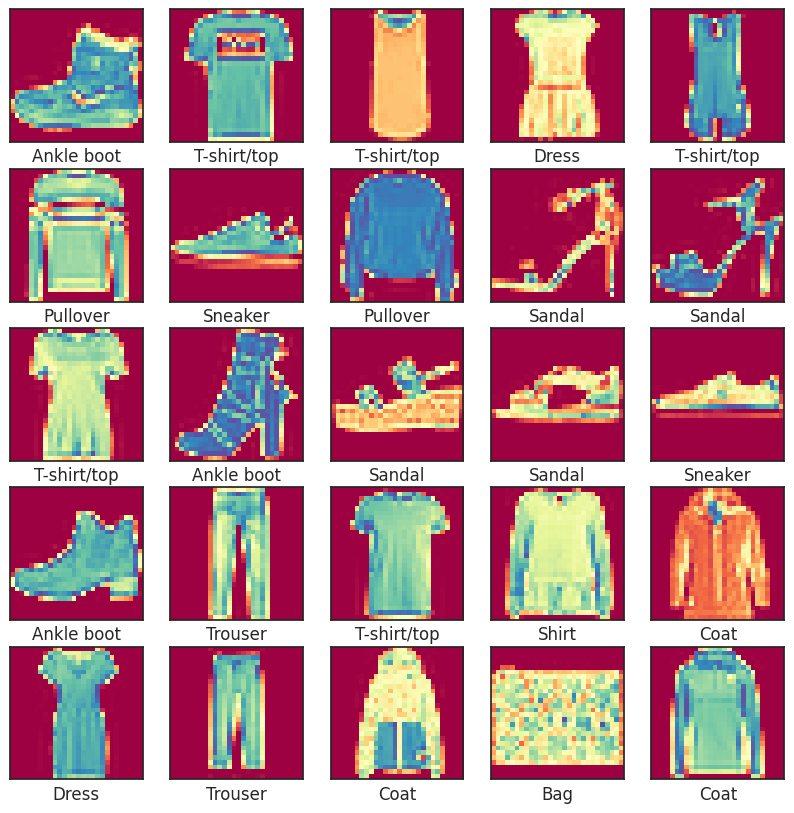

In [17]:
# pruebo imagenes del dataset
# imagen de 5x5 subplots con tamaño de 10x10
sns.set_theme(style="white")
plt.figure(figsize=(10,10))
# recorriendo las imagenes
for i in range(25):
    # creando subplots
    plt.subplot(5,5,i+1)
    # xticks y yticks desactivados
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # tomo la imagen de la columna de datos de la imagen
    # el mapa de colores es viridis de matplotlib
    # otras opciones son: "plasma", "viridis", "BuPu", "hsv", "Spectral"
    plt.imshow(fashion_df["img_data"][i], cmap=plt.cm.Spectral)
    # tomo el nombre de la clase de la columna de etiquetas
    plt.xlabel(fashion_df["label"][i])

## Preprocesar los Datos

Los pasos de esta sección son:

1. Revisar que los datos están bien.
2. Elegir la características o propiedades de aprendizaje.
3. Elegir la variable objetivo del aprendizaje.
4. Dividir el conjunto de datos entre las poblaciones de entrenamiento y pruebas.
5. Formatear los datos de aprendizaje y objetivo acorde a la red neuronal.

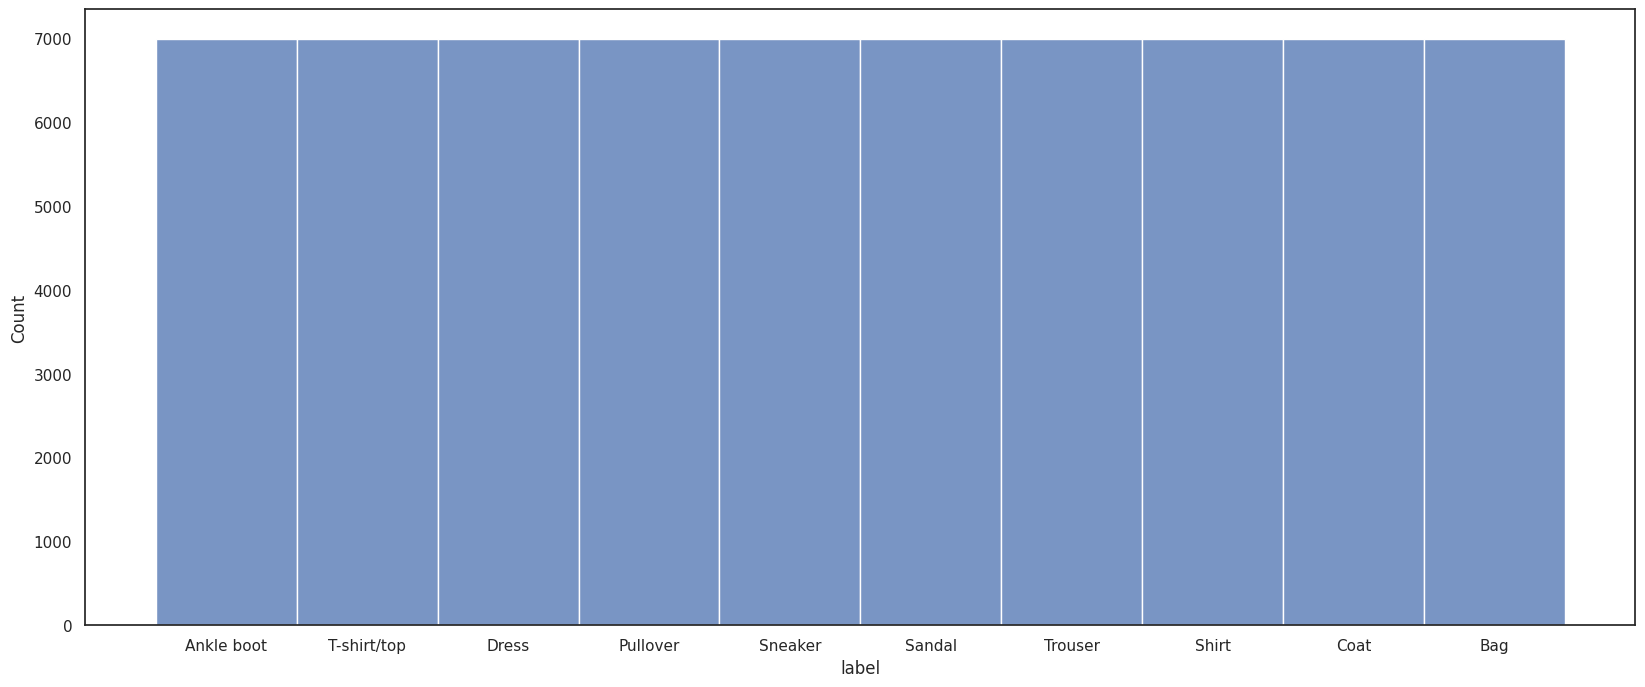

In [18]:
# chequeo la distribucion de datos
sns.set_theme(style="white")
plt.figure(figsize=(20, 8))
sns.histplot(fashion_df[col_names[3]])
plt.show()

In [19]:
# seleccionando caracteristicas de aprendizaje y variables objetivo
# recuperando la forma de las imagenes basado en el primer elemento de la lista

# recuperando los valores y ajustando el tensor para la CNN
A = fashion_df[col_names[4]]
# recuperando los valores de la cateogoria
b = fashion_df[col_names[5]].values

# fortateo de datos numpy
X = np.array([np.array(i, dtype="object") for i in A], dtype="object")
y = np.array([np.array(j, dtype="object") for j in b], dtype="object")

print(X.shape)
# forma basica general de las imagenes
imgsh = X[0].shape
# ajuste de forma para el modelo CNN
X = X.reshape(fashion_df.shape[0], imgsh[0], imgsh[1], 1)
print(X.shape)

(70000, 28, 28)
(70000, 28, 28, 1)


In [20]:
# semilla para el random
rseed = 42

# en tamanho de la muestra para pruebas esta entre 0.2 y 0.3
train_pop = 0.8
test_pop = 1.0 - train_pop

In [21]:
# distribuir los datos entre entrenamiento vs. pruebas
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_pop, random_state=rseed)

In [22]:
# formateo para keras y tensorflow
X_train = tf.convert_to_tensor(X_train, dtype="float64")
y_train = tf.convert_to_tensor(y_train, dtype="float64")
X_test = tf.convert_to_tensor(X_test, dtype="float64")
y_test = tf.convert_to_tensor(y_test, dtype="float64")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

2024-03-03 08:23:59.431484: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-03 08:23:59.431600: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-03 08:23:59.431648: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-03 08:23:59.621908: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-03 08:23:59.622012: I external/local_xla/xla/stream_executor

(56000, 28, 28, 1) (56000, 10) (14000, 28, 28, 1) (14000, 10)


## Definir Modelo CNN

Los pasos de esta sección son:

1. Definir las variables topológicas de la red neuronal.
2. Definir los parámetros de optimización y aprendizaje del modelo.
3. Definir la topología (capas) del modelo.
4. Definir las condiciones de entrenamiento para el modelo.

In [168]:
# defino parametros necesarios para el modelo Autoencoder
# parametros para las capas
# filters, v1 = 32, v2 = 128
filters = 32
# TODO cambiar el numero de neuronas de la capa intermedia
# mid_neurons, v1 = 7*7*filters, v2 = 28*28*filters
mid_neurons = 7*7*filters//2

# TODO cambiar la dimension del reshape convolucional
# mid_reshape, v1 = (7, 7, filters//2), v2 = (28, 28, filters//2)
mid_reshape = (7, 7, filters//2)
ksize = (3, 3)

# TODO cambiar el stride de la convolucion para reducir la imagen
# psize, v1 = (2, 2), v2 = (1, 1)
psize = (2, 2)

# numero de categorias en la salida
categories = len(label_names)

# funcion de activacion para las capas convolucionales
# otras opciones son: # "relu", "LeakyReLU"
act = "LeakyReLU"
# alpha de LeakyReLU
lr_alpha = 0.2

# numero de filtros para la capa de salida
outn = 1
# tamano del kernel para la capa de salida
out_ksize = (1, 1)
# funcion de activacion para la capa de salida
# otras opciones son: # "relu", "sigmoid", "tanh", "LeakyReLU"
out_act = "sigmoid"

# padding para las capas convolucionales
pad = "same"
# porcentaje de dropout para imagenes
ldrop = 0.2

# forma del kernel de entrada y de las capas intermedias
inshape = X[0].shape

# parametros de optimizacion del modelo
# funcion de perdida
# otras opciones son: "mean_squared_error", "mean_absolute_error",
l = "mean_squared_error"
# metodo de optimizacion
opti = "adam"
# metrica de evaluacion
met = ["accuracy"]

# parametros de la bitacora de entrenamiento del modelo, 1 es verbose
ver = 1
# numero de epocas
epo = 30
# tamano del lote de entrenamiento, se recomienda potencia de 2
# otras opciones son: 32, 64, 128, 256
bs = 128         

In [169]:
# definicion de las capas para el Autoencoder
layer_lt = (
    # capa de entrada
    Input(shape=inshape,
          name="LayIn"),

    # CODIFICADOR, capa convolucional intermedia 1
    Conv2D(filters,
           ksize,
           strides=psize,
           activation=LeakyReLU(alpha=lr_alpha,
                                name="EnLeakRelu1"),
           padding=pad,
           name="EnConv1"),
    # LeakyReLU(alpha=lr_alpha,
    #           name="EnLeakRelu1"),
    Dropout(ldrop,
            name="EnDrop1"),

    # capa convolucional intermedia 2
    Conv2D(filters//2,
           ksize,
           strides=psize,
           activation=LeakyReLU(alpha=lr_alpha,
                                name="EnLeakRelu2"),
           padding=pad,
           name="EnConv2"),
    # LeakyReLU(alpha=lr_alpha,
    #           name="EnLeakRelu2"),
    Dropout(ldrop,
            name="EnDrop2"),

    # capa intermedia de 2D a 1D
    Flatten(name="LayFlat"),
    # capa intermedia densamente poblada con regularizacion
    Dense(mid_neurons,
          activation=act,
          name="DenseMid"),
    Dropout(ldrop,
            name="MidDrop"),

    # capa intermedia de 1D a 2D
    Reshape(mid_reshape,
            name="layReshape"),

    # DECODIFICADOR, capa convolucional intermedia 2
    Conv2DTranspose(filters//2,
                    ksize,
                    activation=LeakyReLU(alpha=lr_alpha,
                                         name="DeLeakRelu1"),
                    strides=psize,
                    padding=pad,
                    name="DeConvT2"),
    # LeakyReLU(alpha=lr_alpha,
    #           name="DeLeakRelu1"),
    Dropout(ldrop,
            name="DeDrop2"),

    # capa convolucional intermedia 1
    Conv2DTranspose(filters,
                    ksize,
                    activation=LeakyReLU(alpha=lr_alpha,
                                         name="DeLeakRelu2"),
                    padding=pad,
                    strides=psize,
                    name="DeConvT1"),
    # LeakyReLU(alpha=lr_alpha,
    #           name="DeLeakRelu2"),
    Dropout(ldrop,
            name="DeDrop1"),

    # capa de salida
    Conv2D(outn,
           out_ksize,
           activation=out_act,
        #    padding=pad,
           name="LayOut"),
)

In [170]:
def def_model(layer_lt):
    """def_model crea un modelo de keras con las capas definidas en layer_lt

    Args:
        layer_lt (list): lista de capas de keras

    Returns:
        Model: modelo de keras
    """
    # configurando la primera capa de entrada
    input_ly = layer_lt[0]
    # conmfigurando capa temporal para apilar otras capas
    t_ly = input_ly
    # variable de trabajo para recorrer las capas
    i = 0
    while i < len(layer_lt):
        # print(layer_lt[i].name)
        # si la capa es intermedia
        if i > 0:
            # print("adding inter ly!")
            t_ly = layer_lt[i](t_ly)
        # itero la variable de trabajo
        i += 1
    # configurando la capa de salida como la pila de capas anteriores
    output_ly = t_ly
    # creando el modelo con las capas de entrada y salida
    model = Model(inputs=input_ly, outputs=output_ly)
    # regresando el modelo
    return model

In [171]:
# definiendo el modelo CNN en Keras
cnn_model = def_model(layer_lt)
cnn_model.model_name = "DCNN_Autoencoder"

In [172]:
# compilando las condiciones de optimizacion y ajuste del Modelo CNN
cnn_model.compile(loss=l,
                  optimizer=opti,
                  metrics=met)

In [173]:
# resumen de la topologia del modelo
cnn_model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LayIn (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 EnConv1 (Conv2D)            (None, 14, 14, 32)        320       
                                                                 
 EnDrop1 (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 EnConv2 (Conv2D)            (None, 7, 7, 16)          4624      
                                                                 
 EnDrop2 (Dropout)           (None, 7, 7, 16)          0         
                                                                 
 LayFlat (Flatten)           (None, 784)               0         
                                                                 
 DenseMid (Dense)            (None, 784)               615

La imagen del modelo esta en: Models/discws_cnn_autoencoder.png


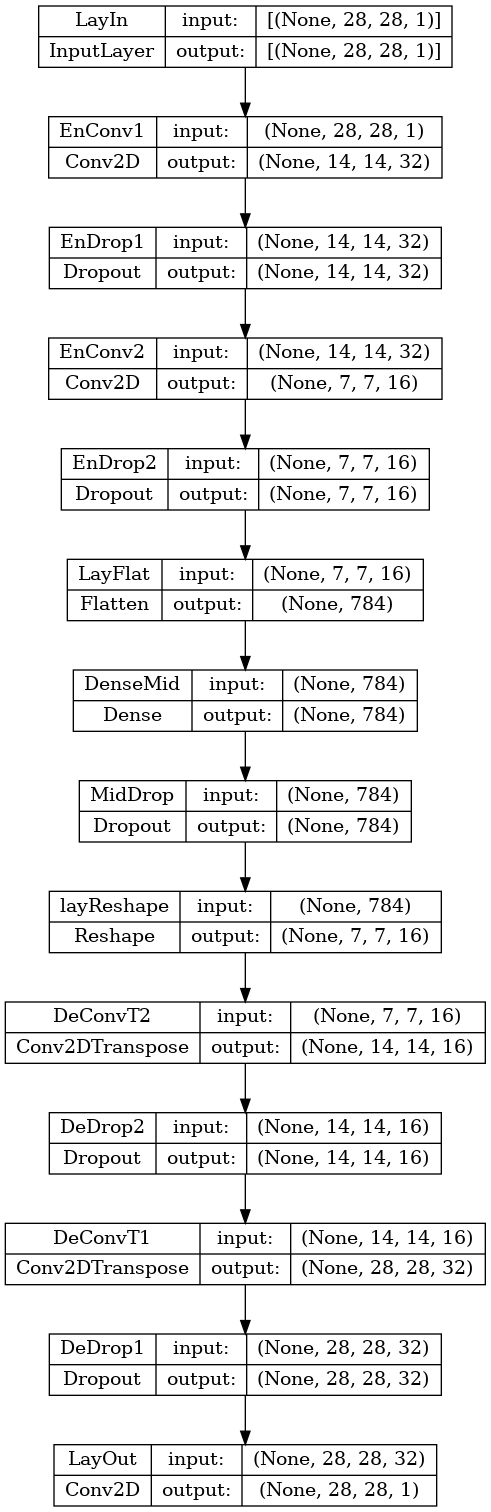

In [174]:
# imprimo imagen de la topologia del modelo
wdir = os.getcwd()
folder_models = "Models"
model_fn = "discws_cnn_autoencoder.png"
model_fp = os.path.join(folder_models, model_fn)
print("La imagen del modelo esta en:", model_fp)
keras.utils.plot_model(cnn_model,
                       model_fp,
                       show_shapes=True)

In [175]:
# condiciones de parada temprana
cnn_earlystop_acc = EarlyStopping(monitor="val_accuracy",
                                  min_delta=0.001,
                                  patience=5,
                                  verbose=ver,
                                  mode="max",
                                  restore_best_weights=True)

## Entrenar Modelo

Los pasos de esta sección son:

1. Entrenar el modelo con el conjunto de entrenamiento.

In [176]:
# ajustando el modelo MLP Keras
cnn_log = cnn_model.fit(
    x=X_train,  # np.array(X_trainB),
    y=X_train,  # to_categorical(np.array(y_trainB), categories),
    batch_size=bs,
    epochs=epo,
    verbose=ver,
    callbacks=[cnn_earlystop_acc],
    workers=8,
    shuffle=False,
    use_multiprocessing=True,
    validation_data=(X_test, X_test),
)

Epoch 1/30


2024-03-03 09:13:25.283348: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_15/EnDrop1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


438/438 [==============================] - 38s 71ms/step - loss: 0.0325 - accuracy: 0.5013 - val_loss: 0.0117 - val_accuracy: 0.5099
Epoch 2/30
438/438 [==============================] - 30s 69ms/step - loss: 0.0137 - accuracy: 0.5071 - val_loss: 0.0084 - val_accuracy: 0.5107
Epoch 3/30
438/438 [==============================] - 30s 68ms/step - loss: 0.0116 - accuracy: 0.5078 - val_loss: 0.0071 - val_accuracy: 0.5109
Epoch 4/30
438/438 [==============================] - 30s 69ms/step - loss: 0.0105 - accuracy: 0.5081 - val_loss: 0.0064 - val_accuracy: 0.5111
Epoch 5/30
438/438 [==============================] - 30s 69ms/step - loss: 0.0099 - accuracy: 0.5083 - val_loss: 0.0059 - val_accuracy: 0.5112
Epoch 6/30
438/438 [==============================] - 30s 68ms/step - loss: 0.0095 - accuracy: 0.5084 - val_loss: 0.0055 - val_accuracy: 0.5113
Epoch 7/30
438/438 [==============================] - 30s 68ms/step - loss: 0.0091 - accuracy: 0.5084 - val_loss: 0.0053 - val_accuracy: 0.5113
Epo

## Probar Modelo

Los pasos de esta sección son:

1. Probar el modelo con el conjunto de pruebas.
2. Evaluar globalmente los resultados.
3. Guardar el modelo entrenado.

In [177]:
cnn_eval = cnn_model.evaluate(x=X_test,
                              y=X_test)

 48/438 [==>...........................] - ETA: 6s - loss: 0.0072 - accuracy: 0.5064

438/438 [==============================] - 8s 18ms/step - loss: 0.0071 - accuracy: 0.5109


In [178]:
# resultados generales
print("Perdida promedio: ", cnn_eval[0])
print("Precision promedio: ", cnn_eval[1])

Perdida promedio:  0.007104461081326008
Precision promedio:  0.5109331011772156


In [179]:
# pruebas sobre el modelo
cnn_predictions = cnn_model.predict(X_test,
                                    verbose=ver)

 16/438 [>.............................] - ETA: 4s

438/438 [==============================] - 5s 12ms/step


In [180]:
# guardar el modelo entrenado
wdir = os.getcwd()
folder_models = "Models"
model_fn = "discws_cnn_autoencoder.keras"
model_fp = os.path.join(folder_models, model_fn)
print("El modelo entrenado esta en:", model_fp)
cnn_model.save(model_fp)
# tf.keras.models.save_model(cnn_autoencoder, model_fp)

El modelo entrenado esta en: Models/discws_cnn_autoencoder.keras


## Mostrar Resultados

Los pasos de esta sección son:

1. Mostrar las curvas de aprendizaje.
2. Mostrar la reconstrucción del Autoencoder.
3. Mostrar la abstracción del Autoencoder.

/tmp/ipykernel_1079/3018473002.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


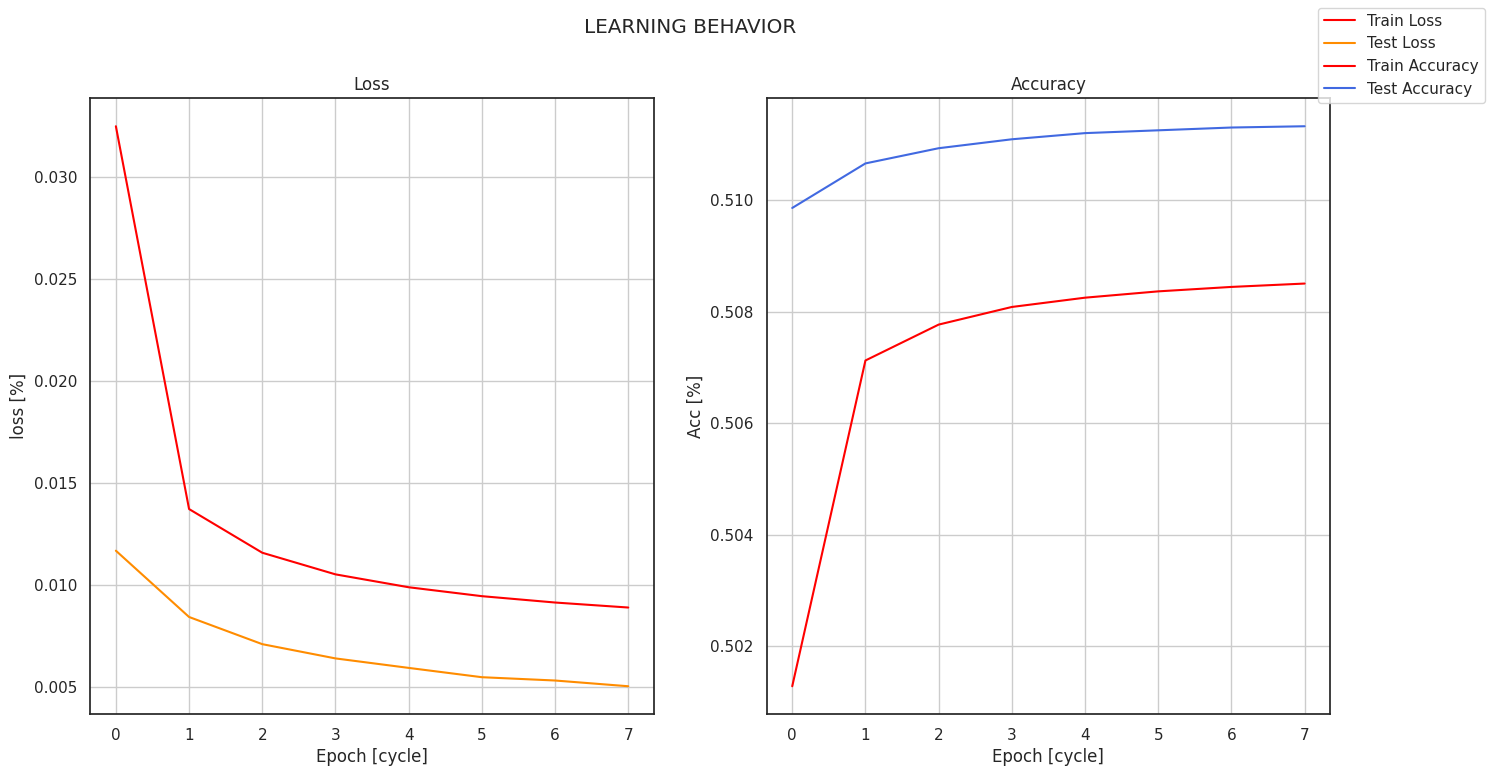

In [181]:
# reporte del aprendizaje
# base de la figura
sns.set_theme(style="white")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# datos de la figura en de perdida y precision
ax1.plot(cnn_log.history["loss"], 'red', label="Train Loss")
ax1.plot(cnn_log.history["val_loss"], 'darkorange', label="Test Loss")
ax2.plot(cnn_log.history["accuracy"], 'red', label="Train Accuracy")
ax2.plot(cnn_log.history["val_accuracy"], 'royalblue', label="Test Accuracy")

# leyenda de la grafica
fig.suptitle("LEARNING BEHAVIOR")
ax1.grid(True)
ax2.grid(True)
ax1.set_title("Loss")
ax2.set_title("Accuracy")
ax1.set(xlabel="Epoch [cycle]", ylabel="loss [%]")
ax2.set(xlabel="Epoch [cycle]", ylabel="Acc [%]")
fig.legend()
fig.show()

In [182]:
# prueba funcional del autoencoder
max_img = 10
random_test_img = np.random.randint(len(X_test), size=max_img)
# random_test_img = range(max_img)
print(len(X_test), len(y_test))
# print(random_test_img)
for img in random_test_img:
    print("Imagen de prueba: ", img)

14000 14000
Imagen de prueba:  12022
Imagen de prueba:  5762
Imagen de prueba:  7289
Imagen de prueba:  10415
Imagen de prueba:  7975
Imagen de prueba:  3734
Imagen de prueba:  7121
Imagen de prueba:  7133
Imagen de prueba:  8924
Imagen de prueba:  11719


In [183]:
middle_layer = "LayFlat"
cnn_abstraction = Model(inputs=cnn_model.input,
                        outputs=cnn_model.get_layer(middle_layer).output)

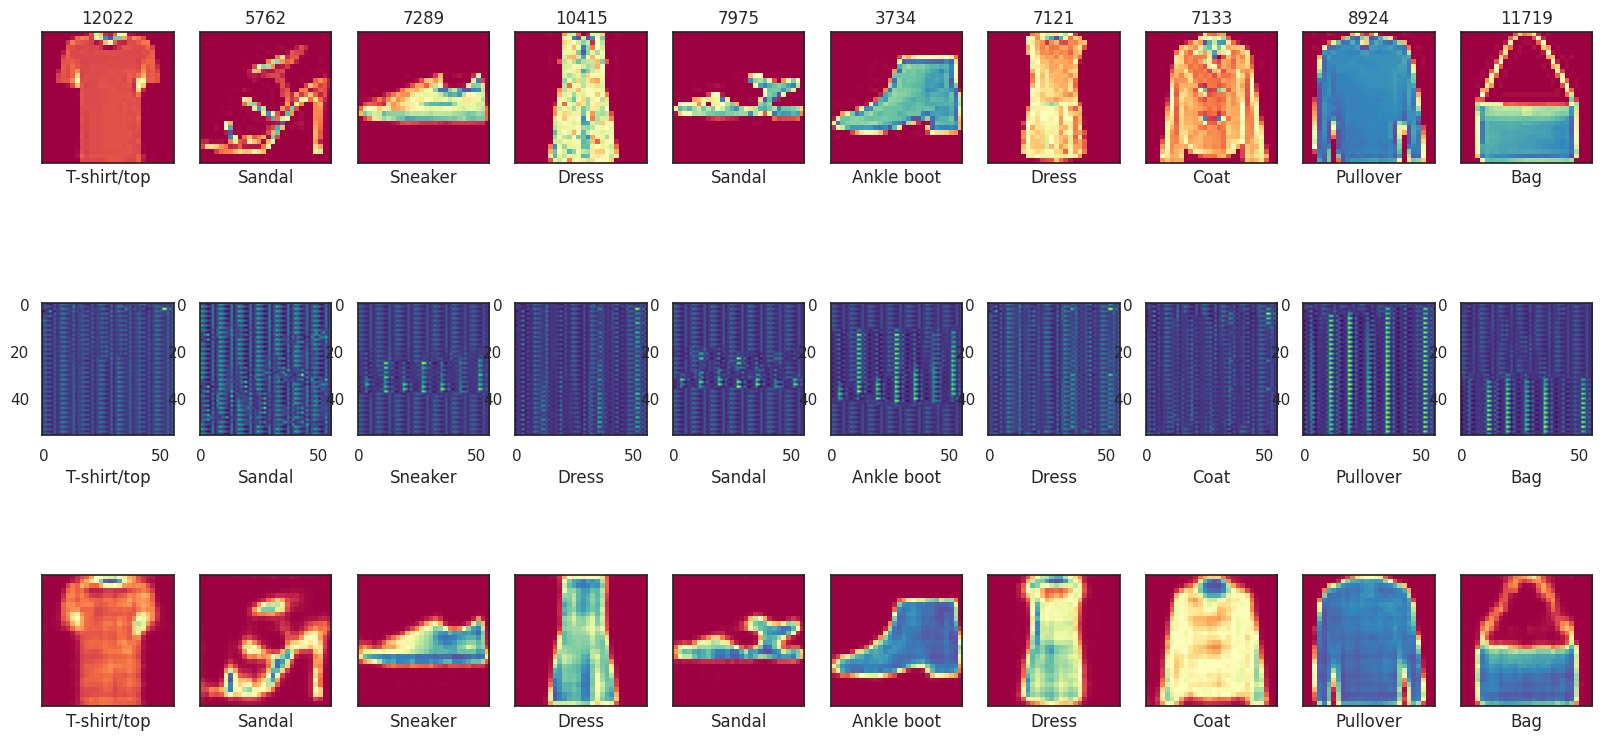

In [184]:
# desplegando pruebas
sns.set_theme(style="white")
plt.figure(figsize=(20, 10))
og_shape = fashion_df[col_names[1]][0]
og_label = fashion_df[col_names[3]][0]

for i, img in enumerate(random_test_img):
    # imagen original
    ax = plt.subplot(3, max_img, i + 1)
    temp_X = np.array(X_test[img])
    # imprimir el nombre de la imagen
    plt.title(img)
    # ajustar ty tamaño y color al original
    plt.imshow(temp_X.reshape(og_shape),
               cmap=plt.cm.Spectral)
    # imprimir el nombre de la clase
    idx = list(y_test[img]).index(max(y_test[img]))
    # print(idx, label_names[idx])
    # print(label_names)
    plt.xlabel(label_names[idx])
    plt.xticks([])
    plt.yticks([])

    # imagen abstracta de la capa intermedia del autoencoder
    ax = plt.subplot(3, max_img, max_img + i + 1)
    # recuperar la imagen abstracta
    temp_abstract = cnn_abstraction(temp_X)
    # formato de la imagen abstracta
    temp_abstract = np.array(temp_abstract)
    # ajusta tamaño y color
    px = temp_abstract.shape[0]*temp_abstract.shape[1]
    px = int(np.sqrt(px))
    # print(px, temp_abstract.shape)
    plt.imshow(temp_abstract.reshape(px, px),
               cmap=plt.cm.viridis)
    # imprimir nombre de la clase
    plt.xlabel(label_names[idx])

    # imagen reconstruida por el autoencoder
    ax = plt.subplot(3, max_img, 2*max_img + i + 1)
    # formatear la imagen reconstruida
    temp_pre = np.array(cnn_predictions[img])
    # ajustar tamaño y color
    plt.imshow(temp_pre.reshape(og_shape),
               cmap=plt.cm.Spectral)
    # imprimir nombre de la clase
    plt.xlabel(label_names[idx])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)